#### IMPORTACIÓN DE LIBRERÍAS NECESARIAS

In [1]:
# Importamos las librerías necesarias
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pydicom as pdicom
import os
import glob
import re 

%matplotlib inline

import cv2
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

#### IMPORTAR LOS DATOS CRUDOS

Creamos una variable llamada "directorio_principal" que es la ruta en la que se encuentran las imágenes del proyecto. Dentro de dicha carpeta, hay dos carpetas más, una para cada tipo de imagen (Benigno vs Maligno). Para cargarlas, creamos otros dos directorios por el tipo de imagen.

In [2]:
directorio_principal = '/Users/laura/Desktop/MASTER/TFM/Imagenes TFM/CMMD'
directorio_benignos = '/Users/laura/Desktop/MASTER/TFM/Imagenes TFM/CMMD/Benignos'
directorio_malignos = '/Users/laura/Desktop/MASTER/TFM/Imagenes TFM/CMMD/Malignos'

A continuación, se realiza la carga de las imágenes. Creamos para ello, un bucle que itere cada uno de los elementos de nuestro directorio de trabajo. 

In [3]:
pacientes_benignos = os.listdir(directorio_benignos)
pacientes_benignos.sort()
# Recolección de todas las imágenes DICOM
imagenes_benignos = []    # Creamos una lista vacía
def load_scan(path):
    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():
                imagenes_benignos.append(os.path.join(dirName,filename))
    return imagenes_benignos
# Añadimos las imágenes a la lista
primer_paciente_benignos = load_scan(directorio_benignos)
print('Nuestro número de imágenes totales que corresponden a tumores benignos es de',len(imagenes_benignos), 'imágenes')

Nuestro número de imágenes totales que corresponden a tumores benignos es de 466 imágenes


Cargamos todos las imágenes en una lista utilizando la función *pdicom.dcmread()*.

In [4]:
ds_benignos = []
for x in range(0,len(imagenes_benignos)):
    img = pdicom.dcmread(imagenes_benignos[x])
    ds_benignos.append(img)

Realizamos exactamente los mismos pasos con las imágenes de los tumores malignos.

In [5]:
pacientes_malignos = os.listdir(directorio_malignos)
pacientes_malignos.sort()
# Recolección de todas las imágenes DICOM
imagenes_malignos = []    # Creamos una lista vacía
def load_scan(path):
    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():
                imagenes_malignos.append(os.path.join(dirName,filename))
    return imagenes_malignos
# Añadimos las imágenes a la lista
primer_paciente_malignos = load_scan(directorio_malignos)
print('Nuestro número de imágenes que corresponden a tumores malignos es de',len(imagenes_malignos), 'imágenes')

Nuestro número de imágenes que corresponden a tumores malignos es de 1283 imágenes


In [6]:
ds_malignos = []
for x in range(0,len(imagenes_malignos)):
    img = pdicom.dcmread(imagenes_malignos[x])
    ds_malignos.append(img)

#### ANÁLISIS EXPLORATORIO DE LOS DATOS

In [8]:
print('Nuestro proyecto está formado en total por', len(ds_benignos) + len(ds_malignos), 'imágenes')

Nuestro proyecto está formado en total por 1749 imágenes


A continuación, vamos a mostrar al azar una imagen al azar de los tumores benignos con su correspondiente clase:

La imagen mostrada es la nº 150 y corresponde a la etiqueta Benignos


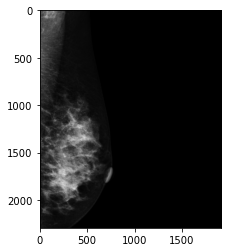

In [9]:
from random import randrange
numero = randrange(len(ds_benignos))
print('La imagen mostrada es la nº', numero, 'y corresponde a la etiqueta Benignos')
plt.imshow(ds_benignos[numero].pixel_array, cmap = plt.cm.gray)

Ahora, hacemos lo mismo con las imágenes correspondientes a los tumores malignos:

La imagen mostrada es la nº 202 y corresponde a la etiqueta Malignos


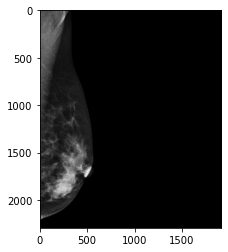

In [20]:
from random import randrange
numero = randrange(len(ds_malignos))
print('La imagen mostrada es la nº', numero, 'y corresponde a la etiqueta Malignos')
plt.imshow(ds_malignos[numero].pixel_array, cmap = plt.cm.gray)

Mostramos la información detallada de la imagen:

In [22]:
ds_malignos[numero]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 208
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital Mammography X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.1239.1759.121949186846077507713942613984
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: '20170818'
(0008, 0013) Instance Creation Time              TM: '115357'
(000

Para analizar mejor los datos podemos crear un *data frame* extrayendo las siguientes características de las imágenes:
- *Clase*: Nos indica la clase de imagen.
- *Tamaño*: Nos indica el tamaño de la imagen.
- *Modo*: Nos indica el modo de imagen, 1-correspondiente a el modo en una escala de grises, 3- correspondiente a *RGB*.

In [57]:
# Para la variable tamaño escogemos del dataset la variable columnas 
# y la variable de filas:
Size = []
for x in range(0, len(ds_benignos)):
    rows = ds_benignos[x].Rows
    columns = ds_benignos[x].Columns
    tamaño = (rows,columns)
    Size.append(tamaño)
    
for x in range(0, len(ds_malignos)):
    rows = ds_malignos[x].Rows
    columns = ds_malignos[x].Columns
    tamaño = (rows,columns)
    Size.append(tamaño)

# Para la variable clase creamos un vector desde 0:
Clase = ["Benigno"] * 466 + ["Maligno"] * 1283

# Extraemos el modo de imagen accediendo al *SamplesPerPixel*:
Mode = []
for x in range(0,len(ds_benignos)):
    samples_pixel = ds_benignos[x].SamplesPerPixel
    Mode.append(samples_pixel)

for x in range(0,len(ds_malignos)):
    samples_pixel = ds_malignos[x].SamplesPerPixel
    Mode.append(samples_pixel)

Creamos un **data frame** con la función del paquete *Pandas*:

In [58]:
df = pd.DataFrame({
    "Clase": Clase,
    "Tamaño": Size,
    "Modo": Mode})

Mostramos nuestro **data frame**:

In [56]:
print(df)

        Clase        Tamaño  Modo
0     Benigno  (2294, 1914)     1
1     Benigno  (2294, 1914)     1
2     Benigno  (2294, 1914)     1
3     Benigno  (2294, 1914)     1
4     Benigno  (2294, 1914)     1
...       ...           ...   ...
1744  Maligno  (2294, 1914)     1
1745  Maligno  (2294, 1914)     1
1746  Maligno  (2294, 1914)     1
1747  Maligno  (2294, 1914)     1
1748  Maligno  (2294, 1914)     1

[1749 rows x 3 columns]


#### PREPROCESAMIENTO DE LOS DATOS

##### REDUCCIÓN Y BALANCEADO DEL CONJUNTO DE DATOS

Para que el conjunto de datos esté balanceado, podemos optar por coger nuestro total de imágenes de benignos ya cargados en la variable *ds_benignos* y escoger al azar la misma cantidad de imágenes del conjunto de datos de malignos.

In [7]:
import random
from random import sample
random.seed('123')
ds_malignos_balanceado = sample(ds_malignos, 466)
len(ds_malignos_balanceado)

466

##### CARGAMOS LAS ETIQUETAS DE IMAGEN EN UNA LISTA

In [8]:
clases = ["Benigno"] * 466 + ["Maligno"] * 466
set(clases)

{'Benigno', 'Maligno'}

##### PREPROCESAMIENTO DE LAS IMÁGENES

In [9]:
def preprocesamiento(img):
    img_pixel_array = img.pixel_array
    # Lo convertimos a color
    img_rgb = cv2.cvtColor(img_pixel_array, cv2.COLOR_GRAY2RGB)
    # Establecemos un tamaño de 256x256
    resized_img = cv2.resize(img_rgb, (256, 256))
    # Normalizamos las imágenes
    img_norm = resized_img/255
    
    return img_norm

In [10]:
X = []
for x in range(0,len(ds_benignos)):
    img_preprocesada = preprocesamiento(ds_benignos[x])
    X.append(img_preprocesada)

In [11]:
for x in range(0, len(ds_malignos_balanceado)):
    img_preprocesada = preprocesamiento(ds_malignos_balanceado[x])
    X.append(img_preprocesada)

##### CODIFICACIÓN DE LAS CLASES

Codificamos las clases, es decir, asignamos valores numéricos de 0 y 1 a cada valor de la variable clase.

In [12]:
# Podemos observar el nombre de las clases:
set(clases)

{'Benigno', 'Maligno'}

In [14]:
# Creamos un diccionario:
diccionario = {'Benigno':0, 'Maligno':1}

In [15]:
# Asignamos a cada clase su valor numérico:
Y = [diccionario.get(n,n) for n in clases]

In [16]:
# Observamos las nuevas clases:
set(Y)

{0, 1}

##### TRANSFORMAMOS LAS LISTAS EN VECTORES

In [17]:
# Utilizamos la función np.array para hacer la transformación:
X = np.array(X)
Y = np.array(Y)

In [18]:
# Comprobamos la longitud de los vectores:
len(X)

932

##### CREAMOS LOS CONJUNTOS DE TRAIN, TEST Y VALIDATION

In [19]:
X_train, X_test, Y_train, Y_test  = train_test_split(X,Y, test_size = 0.25)

In [20]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.25)

In [21]:
print('Entrenamiento', 'Imágenes:',X_train.shape, 'Etiquetas:',Y_train.shape)
print('Test', 'Imágenes:', X_test.shape, 'Etiquetas:',Y_test.shape)
print('Validación', 'Imágenes:', X_valid.shape, 'Etiquetas:',Y_valid.shape)

Entrenamiento Imágenes: (524, 256, 256, 3) Etiquetas: (524,)
Test Imágenes: (233, 256, 256, 3) Etiquetas: (233,)
Validación Imágenes: (175, 256, 256, 3) Etiquetas: (175,)


##### ONE-HOT ENCODING

Se debe realizar un one-hot encoding de la variable clases. Esto significa convertir las clases en una clasificación binaria con 0 y 1. Esto se hace para facilitar el rendimiento y el funcionamiento de la red neuronal. Keras tiene una función llamada to_categorical() que realiza esta función.

In [22]:
from tensorflow.keras.utils import to_categorical

Y_train_oh = to_categorical(Y_train)
Y_test_oh = to_categorical(Y_test)
Y_validation_oh = to_categorical(Y_valid)

print('Etiqueta original:', Y_train[211], ', Etiqueta one-hot encoding:', Y_train_oh[211])

Etiqueta original: 1 , Etiqueta one-hot encoding: [0. 1.]


In [25]:
Y_train.shape

(524,)

In [26]:
X_train[1].shape

(256, 256, 3)

In [82]:
Y_valid.shape

(196,)

In [25]:
X_valid.shape

(149, 256, 256, 3)

#### RED NEURONAL DESDE CERO

Crearemos una red con 4 capas de convolución. La función de activación en cada capa es *ReLu*. En cada capa se realizará un **MaxPoling de 2x2** para reducir la imagen manteniendo las características únicas que detectó cada kernel. A continuación se añade una capa **Flatten()** aplana las características en un vector unidemensional.

In [23]:
modelo_1 = Sequential()

modelo_1.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation = 'relu'))
modelo_1.add(MaxPooling2D(pool_size=(2, 2)))

modelo_1.add(Conv2D(64, (3, 3), activation = 'relu'))
modelo_1.add(MaxPooling2D(pool_size=(2, 2)))

modelo_1.add(Conv2D(128, (3, 3), activation = 'relu'))
modelo_1.add(MaxPooling2D(pool_size=(2, 2)))

modelo_1.add(Conv2D(512, (3, 3), activation = 'relu'))
modelo_1.add(MaxPooling2D(pool_size=(2, 2)))

modelo_1.add(Flatten()) 

modelo_1.add(Dense(512, activation = 'relu'))

modelo_1.add(Dropout(0.2))

modelo_1.add(Dense(2, activation = 'sigmoid'))

modelo_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 512)       5

In [24]:
from tensorflow import keras
modelo_1.compile(loss = 'binary_crossentropy', 
                optimizer = keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [25]:
batch_size = 64
resumen_1 = modelo_1.fit(X_train, Y_train_oh,
                        batch_size = 64,
                        epochs = 10,
                        steps_per_epoch = len(X_train) // batch_size,
                        verbose = 1,
                        validation_data = (X_valid, Y_validation_oh),
                        validation_steps = len(X_valid) // batch_size)

Epoch 1/10
8/8 [==============================] - 495s 55s/step - loss: 0.7150 - accuracy: 0.5898 - val_loss: 0.6766 - val_accuracy: 0.6094
Epoch 2/10
8/8 [==============================] - 38s 5s/step - loss: 0.6584 - accuracy: 0.6370 - val_loss: 0.6728 - val_accuracy: 0.6094
Epoch 3/10
8/8 [==============================] - 39s 5s/step - loss: 0.6429 - accuracy: 0.6500 - val_loss: 0.6967 - val_accuracy: 0.6094
Epoch 4/10
8/8 [==============================] - 39s 5s/step - loss: 0.6534 - accuracy: 0.6217 - val_loss: 0.6635 - val_accuracy: 0.6094
Epoch 5/10
8/8 [==============================] - 38s 5s/step - loss: 0.6486 - accuracy: 0.6478 - val_loss: 0.6939 - val_accuracy: 0.6172
Epoch 6/10
8/8 [==============================] - 38s 5s/step - loss: 0.6393 - accuracy: 0.6587 - val_loss: 0.6734 - val_accuracy: 0.6094
Epoch 7/10
8/8 [==============================] - 37s 4s/step - loss: 0.6375 - accuracy: 0.6478 - val_loss: 0.6588 - val_accuracy: 0.6016
Epoch 8/10
8/8 [================

In [28]:
from tensorflow.keras.models import model_from_json
model1_json = modelo_1.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model1_json)
# serialize weights to HDF5
modelo_1.save_weights("model_1.h5py")

In [29]:
test_eval = modelo_1.evaluate(X_test,Y_test_oh, verbose = 1)

8/8 [==============================] - 6s 646ms/step - loss: 0.7271 - accuracy: 0.5923


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

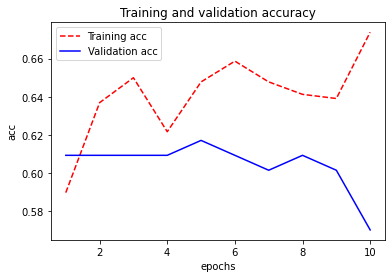

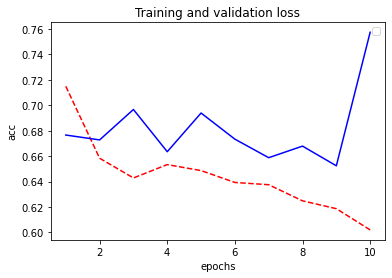

<Figure size 432x288 with 0 Axes>

In [31]:
acc      = resumen_1.history['accuracy']
val_acc  = resumen_1.history['val_accuracy']
loss     = resumen_1.history['loss']
val_loss = resumen_1.history['val_loss']

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--' )
plt.plot ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

#### IMPORTAMOS LAS LIBRERÍAS NECESARIAS

In [32]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random
from random import sample
from tensorflow.keras.models import model_from_json

#### MEJORA DEL MODELO

##### TRANSFER LEARNING


Una forma de mejorar el modelo es utilizar un modelo preentrenado. Una de ellas es la **covnet VGG16**, que es la que utilizaremos. Incluimos el parámetro *include_top = False* para utilizar nuestro propio clasificador densamente conectado con nuestras dos clases.

In [33]:
from tensorflow.keras.applications import VGG16

VGG16_model = VGG16(input_shape = (256,256,3),
                        include_top = False,
                        weights = 'imagenet')

VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

Establecemos el modelo densamente conectado:

In [35]:
inputs = keras.Input(shape=(256,256,3))

x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(2, activation='sigmoid')(x)

model_2 = keras.Model(inputs, outputs)
model_2.compile(loss='binary_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='feature_extraction.keras',
    save_best_only=True,
    monitor='val_loss')]

resumen_2 = model_2.fit(
  X_train, Y_train_oh,
  epochs=50,
  validation_data = (X_valid, Y_validation_oh),
  callbacks=callbacks)

Epoch 1/50
17/17 [==============================] - 100s 3s/step - loss: 69.0095 - accuracy: 0.5191 - val_loss: 79.9300 - val_accuracy: 0.5829
Epoch 2/50
17/17 [==============================] - 9s 496ms/step - loss: 35.6212 - accuracy: 0.6240 - val_loss: 38.7458 - val_accuracy: 0.4171
Epoch 3/50
17/17 [==============================] - 8s 471ms/step - loss: 33.8618 - accuracy: 0.5706 - val_loss: 40.1990 - val_accuracy: 0.5829
Epoch 4/50
17/17 [==============================] - 8s 447ms/step - loss: 32.1219 - accuracy: 0.6050 - val_loss: 27.8193 - val_accuracy: 0.5829
Epoch 5/50
17/17 [==============================] - 8s 446ms/step - loss: 29.6203 - accuracy: 0.6126 - val_loss: 41.8843 - val_accuracy: 0.5886
Epoch 6/50
17/17 [==============================] - 115s 5s/step - loss: 25.5201 - accuracy: 0.6527 - val_loss: 20.4402 - val_accuracy: 0.5257
Epoch 7/50
17/17 [==============================] - 9s 541ms/step - loss: 25.8788 - accuracy: 0.6202 - val_loss: 38.4448 - val_accuracy: 0

Guardamos el modelo:

In [37]:
model_2_json = model_2.to_json()
model_2.save_weights("model_2.h5py")

Evaluamos el modelo:

In [38]:
test_lost, test_acc= model1.evaluate(X_valid, Y_validation_oh)
print ("Test Accuracy:", test_acc)

6/6 [==============================] - 1s 34ms/step - loss: 0.7386 - accuracy: 0.4743
Test Accuracy: 0.47428572177886963


Estos son los resultados:

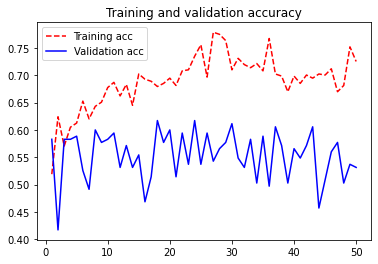

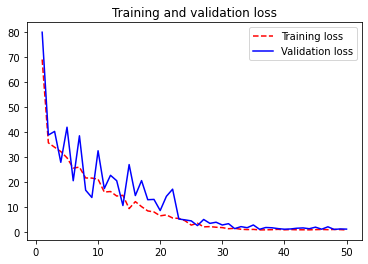

In [41]:
import matplotlib.pyplot as plt
acc = resumen_2.history['accuracy']
val_acc = resumen_2.history['val_accuracy']
loss = resumen_2.history['loss']
val_loss = resumen_2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()